# Machine Learning: Assignment 3
**黄绵秋 19307130142**

## 任务描述
- 实现逻辑回归算法
- 通过逻辑回归分类算法对`breast_cancer`数据集进行预测

## 数据描述
- `breast_cancer`数据集一共包含569组数据，按照恶性`malignant`和良性`benign`分为两类，分别被标注为0和1，每组数据包含30个特征
- 将特征数据和标签数据分别从`sklearn.datasets`中导出到变量`X,y`中
- `breast_cancer`数据集的一些信息如下

In [1]:
from sklearn import datasets
import numpy as np
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target
print('data_size:', len(X))
print('feature_numbers:', len(X[0]))
print('target_names:',cancer.target_names)
print(cancer.DESCR)

data_size: 569
feature_numbers: 30
target_names: ['malignant' 'benign']
.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each imag

## 数据描述
- 通过观察各个特征的数值大小，可以发现各个特征之间数量级差距较大，故而需要进行归一化处理

In [2]:
print(X[0])
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X=X)
X = np.pad(X, ((0,0),(1,0)), 'constant', constant_values=(1))       #为X填充x_0=1
print(X[0])

[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
 1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
 6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
 1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
 4.601e-01 1.189e-01]
[1.         0.52103744 0.0226581  0.54598853 0.36373277 0.59375282
 0.7920373  0.70313964 0.73111332 0.68636364 0.60551811 0.35614702
 0.12046941 0.3690336  0.27381126 0.15929565 0.35139844 0.13568182
 0.30062512 0.31164518 0.18304244 0.62077552 0.14152452 0.66831017
 0.45069799 0.60113584 0.61929156 0.56861022 0.91202749 0.59846245
 0.41886396]


- 为对回归结果进行有效评估，将数据分割成训练集和测试集两部分，其中70%为训练集，30%为测试集。

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021, shuffle=True)
print('数据集size:\n', '训练集', X_train.shape, y_train.shape, '\n 测试集', X_test.shape, y_test.shape)

数据集size:
 训练集 (398, 31) (398,) 
 测试集 (171, 31) (171,)


## 逻辑回归模型
### 模型回归概述
`LogisticRegression`逻辑回归是一种分类模型，常用于二分类，它假设数据服从伯努利分布。相比于`LinearRegression`引入了`Sigmoid function`以加入非线性因素，从而解决二分类问题
### 模型推导
#### 符号规定
$x_j^{(i)}$表示数据集第$i$个数据的第$j$个属性取值，$y^{(i)}$表示数据集第$i$个数据的标签值，$\hat{y}^{(i)}$表示第$i$组数据的计算预测值。数据集一共有$m$个数据，$n$种属性。

矩阵形式表示，$x_i=\begin{bmatrix}1 & x_1^{(i)} & \cdots & x_n^{(i)}\end{bmatrix}$，$X=\begin{bmatrix}1 & x_1^{(1)} & \cdots & x_n^{(1)} \\ 1 & x_1^{(2)} & \cdots & x_n^{(2)} \\ \cdots & \cdots & \cdots & \cdots \\ 1 & x_1^{(m)} & \cdots & x_n^{(m)}\end{bmatrix}$，参数$W=\begin{bmatrix}w_0 \\ w_1 \\ \vdots \\ w_n\end{bmatrix}$，数据集标签为$y=\begin{bmatrix}y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(m)}\end{bmatrix}$

#### 模型目标
在二分类问题中，我们只需要一个线性判别函数$f(x; w) = w^Tx$，其中$x,w$分别为增广特征向量和增广权重向量，特征空间$\mathbb{R}^D$中所有满足$f(x; w) = 0$ 的点组成一个分割超平面（Hyperplane），称为决策边界（Decision Boundary）或决策平面（Decision Surface）。决策边界将特征空间一分为二，划分成两个区域，每个区域对应一个类别。

也即，对于给定$N$个样本的训练集$\mathcal{D}=\{(x^{(n)},y^{(n)})\}_{n=1}^N$，其中$y^{(n)}\in\{0,1\}$，线性模型试图学习到参数$w^*$，使得对于每个样本$(x^{(n)},y^{(n)})$尽量满足
$$f(x^{(n)}; w^*) > \frac{1}{2}\qquad if\ \ y^{(n)} = 1\\f(x^{(n)}; w^*) < \frac{1}{2}\qquad if\ \ y^{(n)} = 0$$

#### 理论描述
而我们的线性模型是连续的，并不适合这种分类，所以我们需要引入非线性函数$g:\mathbb{R}^D\rightarrow (0,1)$来预测类别标签的后验概率$p(y=1|x)$
$$p(y=1|x) =g(f(x;w))$$
其中$g(\cdot)$被称为激活函数，其作用是把线性函数的值域从实数区间挤压到了(0, 1)之间，可以用来表示概率。在`LogisticRegression`中我们使用标准`Logistic`函数作为激活函数，因而标签$y=1$的后验概率为
$$\begin{align*}p(y=1|x)&=\sigma(w^Tx)
\\&\triangleq\frac{1}{1+exp(-w^Tx)}\end{align*}$$
变换得到
$$\begin{align*}w^Tx&=ln\frac{p(y=1|x)}{1-p(y=1|x)}\\&=ln\frac{p(y=1|x)}{p(y=0|x)}\end{align*}$$

#### 参数学习
在`LogisticRegression`中我们采用交叉熵作为损失函数，并使用梯度下降法对参数进行优化
> 信息量的大小与信息发生的概率成反比，因而用来表示所有信息量的期望的信息熵在分类问题中十分有效，交叉熵可以衡量同一个随机变量中两个不同概率分布的差异程度，在机器学习中就表示为概率分布与预测概率分布之间的差异。

> @ref [交叉熵损失函数原理详解](https://blog.csdn.net/b1055077005/article/details/100152102)

给定$N$个训练样本$\{(x^{(n)},y^{(n)})\}_{n=1}^N$，用`LogisticRegression`模型对每个样本$x^{(n)}$进行预测，输出其标签为1的后验概率，记为$\hat{y}^{(n)}$
$$\hat{y}^{(n)}=\sigma(w^Tx^{(n)}),\qquad 1\leq n\leq N$$
由于$y^{(n)}\in\{0,1\}$，样本$(x^{(n)},y^{(n)})$的真实条件概率可以表示为
$$p_r(y^{(n)}=1|x^{(n)})=y^{(n)}\\
p_r(y^{(n)}=0|x^{(n)})=1-y^{(n)}$$
使用交叉熵损失函数，其风险函数为
$$\begin{align*}\mathcal{R}(w)&=-\frac{1}{N}\sum_{n=1}^N\left(p_r(y^{(n)}=1|x^{(n)})log\ \hat{y}^{(n)}+p_r(y^{(n)}=0|x^{(n)})log(1-\hat{y}^{(n)})\right)\\
&=-\frac{1}{N}\sum_{n=1}^N\left(y^{(n)}log\ \hat{y}^{(n)}+(1-y^{(n)})log(1-\hat{y}^{(n)})\right)\end{align*}$$
其关于参数$w$的偏导数为
$$\begin{align*}
\frac{\partial \mathcal R(w)}{\partial w}
&=-\frac{1}{N}\sum_{n=1}^N\left(y^{(n)}\frac{\hat{y}^{(n)}(1-\hat{y}^{(n)})}{\hat{y}^{(n)}}x^{(n)}-(1-y^{(n)})\frac{\hat{y}^{(n)}(1-\hat{y}^{(n)})}{1-\hat{y}^{(n)}}x^{(n)}\right)\\
&=-\frac{1}{N}\sum_{n=1}^N\left(y^{(n)}(1-\hat{y}^{(n)})x^{(n)}-(1-y^{(n)})\hat{y}^{(n)}x^{(n)}\right)\\
&=-\frac{1}{N}\sum_{n=1}^Nx^{(n)}(y^{(n)}-\hat{y}^{(n)})
\end{align*}$$
采用梯度下降法，`LogisticRegression`的训练过程为:初始化$w\leftarrow 0$，然后通过下式来迭代更新参数:
$$w_{t+1}\leftarrow w_t+\alpha\frac{1}{N}\sum_{n=1}^Nx^{(n)}(y^{(n)}-\hat{y}^{(n)}_{w_t})$$
其中$\alpha$为学习率，$\hat{y}^{(n)}_{w_t}$为当参数为$w_t$时，`LogisticRegression`模型的输出

### 模型实现


#### 超参类

In [4]:
class Hyperameters():
    def __init__(self, feature_dimension, data_size, alpha=0.99, max_epoch=1000, eps=0.0001):
        self.feature_dimension = feature_dimension
        self.data_size = data_size
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.eps = eps
    
    def toString(self):
        return str.format("feature_dimension:{0}, data_size:{1}\nalpha:{3}, max_epoch:{4}", self.feature_dimension, self.data_size, self.alpha, self.max_epoch)

#### 逻辑回归类

In [5]:
class LogisticRegression():
    def __init__(self, hp):
        """Initialize variable matrix W

        Args:
            hp (Hyperameter)
        """
        self.hp = hp
        self.W = np.zeros((self.hp.feature_dimension, ))
        return

    def cal_loss(self, X, y):
        """calculate the loss function using input matrix X and vector y

        Args:
            X (numpy.array((sample_number, feature_dimension))): matrix X
            y (numpy.array((feature_dimension, ))): vector y

        Returns:
            [float]: the loss of the training data
            [numpy.array]: delta W
        """

        m = X.shape[0]
        y_hat = self.predict(X)
        loss = np.sum((y*np.log(y_hat)+(1-y)*np.log(1-y_hat)))
        loss = - loss / m
        dw = - np.dot(X.T, (y - y_hat)) / m
        return loss, dw

    def train(self, X, y, loss_print=False, early_termination=True):
        """Use input matrix X and vector y to train the model.

        Args:
            X (numpy.array((sample_number, feature_dimension))): matrix X
            y (numpy.array((feature_dimension, ))): vector y
            learning_rate (float, optional): learning rate(may also called alpha). Defaults to 0.99.
            iteration (int, optional): Number of iterations. Defaults to 1000.
            loss_print (bool, optional): True if want to print the loss. Defaults to False.
        """
        loss, dw = 0, 0
        history = []
        epoch_count = 0
        pre_loss = 0
        for _ in range(self.hp.max_epoch):
            epoch_count += 1
            pre_loss = loss
            loss, dw = self.cal_loss(X, y)
            self.W = self.W - self.hp.alpha * dw
            history.append(loss)
            if early_termination and  np.abs(pre_loss - loss) < self.hp.eps:
                break

        if loss_print:
            import matplotlib.pyplot as plt
            plt.plot(range(epoch_count+1)[1:], history)
            plt.xlabel('iteration')
            plt.ylabel('loss')
            plt.show()
        return history, epoch_count        


    def predict(self, X):
        """Use variable matriX W to predict the label result

        Args:
            X (numpy.array((test_sample, feature_dimension))): the input matrix X

        Returns:
            [float]: the prediction of the label result.
        """
        return 1/(1 + np.exp(-X.dot(self.W)))

### 模型结果
利用训练出的模型对测试集中的数据进行预测，若预测值超过0.5则认为为标签1，否则为标签0，根据预测正确的数量比上总测试数据数量得到正确率。
分别用分割训练集和kFold算法方式进行检验。

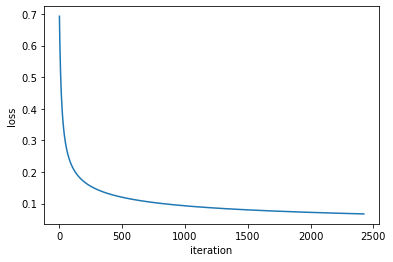

Logistic regression with 2424 iterations test score: 0.9649
Logistic regression with kFold algorithm get score: 0.9842


In [6]:
def score(test_result, y_test):
    counter = 0
    acc = 0
    for (pred_label, true_label) in zip(test_result, y_test):
        counter += 1
        if pred_label == true_label:
            acc += 1
    return acc/counter

from sklearn.model_selection import KFold
def score_with_kfold(X, y, model):
    kf = KFold(n_splits=10, shuffle=True, random_state=2021)
    scores = []
    for train_index, test_index in kf.split(X):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        model.train(X_train, y_train)
        test_result = model.predict(X_test).round()
        scores.append(score(test_result, y_test))
    return np.mean(scores)

hp = Hyperameters(X_train.shape[1], X_test.shape[0], alpha=0.9, max_epoch=10000, eps=0.00001)
lr = LogisticRegression(hp)
_, epoch_count = lr.train(X_train, y_train, loss_print=True)
test_result = lr.predict(X_test).round()
print('Logistic regression with %d iterations test score: %.4f' % (epoch_count, score(test_result, y_test)))
kfold_lr = LogisticRegression(hp)
print('Logistic regression with kFold algorithm get score: %.4f' % score_with_kfold(X, y, kfold_lr))


### 模型调参
接下来我们通过调参比较正确率的方式找到合适的超参

In [7]:
import matplotlib.pyplot as plt
hp_list = []
np.random.seed(2021)
rand_alpha = np.random.rand(50)
scores = []
for item in rand_alpha:
    hp_list.append(Hyperameters(X_train.shape[1], X_test.shape[0], alpha=item, max_epoch=1000))
for alpha, item in zip(rand_alpha, hp_list):
    lr = LogisticRegression(item)
    _, epoch_count = lr.train(X_train, y_train, loss_print=False, early_termination=False)
    test_result = lr.predict(X_test).round()
    scores.append(score(test_result, y_test))
    # print('Logistic regression with %d iterations using learning rate %.4f gets test score: %.4f' % (epoch_count, alpha, score(test_result, y_test)))
    

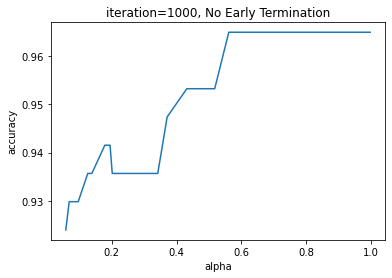

In [8]:
sorted_alpha, sorted_scores = (list(t) for t in zip(*sorted(zip(rand_alpha, scores), reverse=False)))
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('iteration=1000, No Early Termination')
plt.plot(sorted_alpha, sorted_scores)
plt.show()

由此可以看到应让学习率为接近1的值，在之后的讨论中会使用0.9的学习率。接下来再考察不同迭代次数的影响，此处会禁用提前终止。

In [9]:
hp_list = []
scores = []
epoch_list = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
for item in epoch_list:
    hp_list.append(Hyperameters(X_train.shape[1], X_test.shape[0], alpha=0.9, max_epoch=item))
for epoch, item in zip(epoch_list, hp_list):
    lr = LogisticRegression(item)
    _, epoch_count = lr.train(X_train, y_train, loss_print=False, early_termination=False)
    test_result = lr.predict(X_test).round()
    scores.append(score(test_result, y_test))

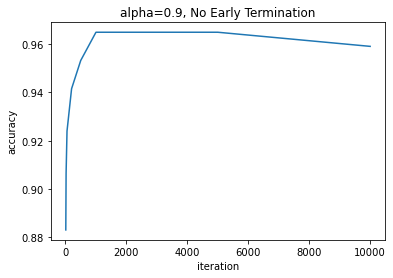

In [10]:
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('alpha=0.9, No Early Termination')
plt.plot(epoch_list, scores)
plt.show()

由此可以看出迭代次数在2000-6000时有较好的效果，迭代次数太多也并不好，可能会出现过拟合而导致准确率下降。

### 模型优化
与`LinearRegression`类似，`LogisticRegression`也可以通过引入$L1,L2$正则化进行优化，从而降低过拟合的概率，使得结果更可信。
#### $L1$正则化实现

In [11]:
class LogisticRegressionL1(LogisticRegression):
    def __init__(self, hp, lambdaI):
        super().__init__(hp)
        self.lambdaI = lambdaI

    def cal_loss(self, X, y):
        loss, dw =  super().cal_loss(X, y)
        l = self.lambdaI
        w = self.W
        loss += l * np.sum(np.power(w, 2))
        dw += 2 * l * w
        return loss, dw

#### $L2$正则化实现

In [12]:
class LogisticRegressionL2(LogisticRegression):
    def __init__(self, hp, lambdaI):
        super().__init__(hp)
        self.lambdaI = lambdaI

    def cal_loss(self, X, y):
        loss, dw =  super().cal_loss(X, y)
        l = self.lambdaI
        w = self.W
        dw += l*(len(w)-len(w[w < 0]))
        return loss, dw

#### 优化结果

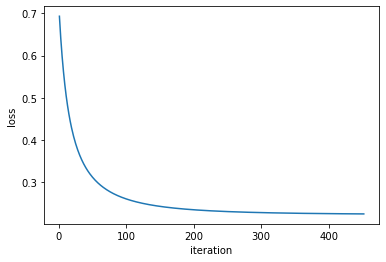

Logistic regression with L1 normalization with 452 iterations test score: 0.9415


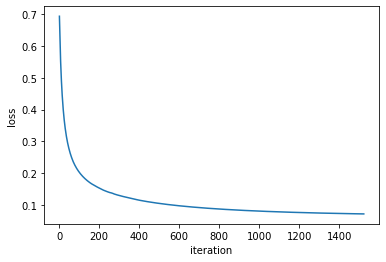

Logistic regression with L2 normalization with 1522 iterations test score: 0.9649
Logistic regression with L1 normalization with kFold algorithm get score: 0.9596
Logistic regression with L2 normalization with kFold algorithm get score: 0.9666


In [13]:
hp = Hyperameters(X_train.shape[1], X_test.shape[0], alpha=0.9, max_epoch=10000, eps=0.00001)
lr_l1 = LogisticRegressionL1(hp, lambdaI=0.001)
lr_l2 = LogisticRegressionL2(hp, lambdaI=0.001)
_, epoch_count = lr_l1.train(X_train, y_train, loss_print=True)
test_result = lr_l1.predict(X_test).round()
print('Logistic regression with L1 normalization with %d iterations test score: %.4f' % (epoch_count, score(test_result, y_test)))
_, epoch_count = lr_l2.train(X_train, y_train, loss_print=True)
test_result = lr_l2.predict(X_test).round()
print('Logistic regression with L2 normalization with %d iterations test score: %.4f' % (epoch_count, score(test_result, y_test)))
kfold_lr_l1 = LogisticRegressionL1(hp, lambdaI=0.001)
print('Logistic regression with L1 normalization with kFold algorithm get score: %.4f' % score_with_kfold(X, y, kfold_lr_l1))
kfold_lr_l2 = LogisticRegressionL2(hp, lambdaI=0.001)
print('Logistic regression with L2 normalization with kFold algorithm get score: %.4f' % score_with_kfold(X, y, kfold_lr_l2))

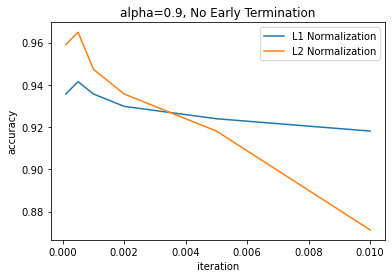

In [14]:
lambda_list = [0.01, 0.005, 0.002, 0.001, 0.0005, 0.0001]
scores_l1 = []
scores_l2 = []
hp = Hyperameters(X_train.shape[1], X_test.shape[0], alpha=0.9, max_epoch=10000)
for item in lambda_list:
    lr_l1 = LogisticRegressionL1(hp, item)
    lr_l2 = LogisticRegressionL2(hp, item)
    _, epoch_count_l1 = lr_l1.train(X_train, y_train, loss_print=False, early_termination=True)
    _, epoch_count_l2 = lr_l2.train(X_train, y_train, loss_print=False, early_termination=True)
    test_result = lr_l1.predict(X_test).round()
    scores_l1.append(score(test_result, y_test))
    test_result = lr_l2.predict(X_test).round()
    scores_l2.append(score(test_result, y_test))

plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('alpha=0.9, No Early Termination')
plt.plot(lambda_list, scores_l1, label='L1 Normalization')
plt.plot(lambda_list, scores_l2, label='L2 Normalization')
plt.legend()
plt.show()

可以看出，在加入正则化后，模型经过更少的迭代次数即可达到较稳定的`loss`值，这表明模型更加稳定了。并且加入两种正则化后仍保持了极高的准确率，在学习率很小时$L2$正则化的准确率略高于$L1$正则化。

## 总结
通过训练逻辑回归模型，对`breast_cancer`数据集进行了性能优秀的二分类。通过为防止过拟合问题，采用了归一化的方式进行数据预处理，引入$L1,L2$正则化以使模型更稳定，通过提前终止的方式提前结束迭代防止过拟合。并通过控制变量考察了各个超参的最佳选取范围。最终分类的准确率达到0.96左右。